In [ ]:
import pandas as pd
import numpy as np

In [ ]:
last = pd.read_csv("./data/data_last.csv", dtype={'ticker': str, 'date': str, 'last': float}, parse_dates=['date'])
mkt_cap = pd.read_csv('./data/data_mkt_cap.csv', dtype={'ticker': str, 'date': str, 'mktcap': float}, parse_dates=['date'])
volume = pd.read_csv('./data/data_volume.csv', dtype={'ticker': str, 'date': str, 'volume': float}, parse_dates=['date'])
sector = pd.read_csv('./data/data_sector.csv', dtype={'ticker': str, 'sector': str})

In [ ]:
def data_process(last: pd.DataFrame, mkt_cap: pd.DataFrame, volume: pd.DataFrame):
    def fillna(data):
        ticker = data['ticker']
        data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
        data['ticker'] = ticker
        return data
    # fill NAN by using ffill for each stock id
    if last.isnull().values.any():
        last = fillna(last)
    if volume.isnull().values.any():
        volume = fillna(volume)
    if mkt_cap.isnull().values.any():
        mkt_cap =fillna(mkt_cap)
    last.set_index(['ticker', 'date'], inplace=True)
    volume.set_index(['ticker', 'date'], inplace=True)
    mkt_cap.set_index(['ticker', 'date'], inplace=True)

    # merge data
    data = pd.concat([last, volume, mkt_cap], axis=1).reset_index()

    return data

#data = data_process(last, volume, mkt_cap)

In [ ]:
class DataLoader:
    def __init__(self, last, volume, mkt_cap ,standard=True, outliers=True, neutral_sec=True, neutral_mkt=True):
        self.standard = standard
        self.outliers = outliers
        self.neutral_sec = neutral_sec
        self.neutral_mkt = neutral_mkt

        self.data = data_process(last, volume, mkt_cap)
        self.data['ret'] = self.data.groupby('ticker')['last'].pct_change()

data_loader = DataLoader(last, volume, mkt_cap)

<ipython-input-6-22d845558787>:4: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
<ipython-input-6-22d845558787>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
<ipython-input-6-22d845558787>:4: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
<ipython-input-6-22d845558787>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date')

In [ ]:
#data = pd.concat([last.set_index(['ticker', 'date']), volume.set_index(['ticker', 'date']), mkt_cap.set_index(['ticker', 'date'])], axis=1).reset_index()
data = data_loader.data
data

,ticker,date,last,mkt_cap,volume
0,1332 JT,2017-08-16,562.12,199642.95,1641300.0
1,5411 JT,2017-08-16,1688.53,1344084.00,2338400.0
2,4272 JT,2017-08-16,1386.45,304780.96,437000.0
3,7733 JT,2017-08-16,909.24,1293584.94,4453200.0
4,5214 JT,2017-08-16,3055.06,396600.14,687900.0
...,...,...,...,...,...
420532,6508 JT,2024-03-06,2791.00,127067.37,175000.0
420533,6503 JT,2024-03-06,2458.50,5278895.01,5130000.0
420534,7832 JT,2024-03-06,2915.50,1941723.00,2422400.0
420535,2503 JT,2024-03-06,2064.00,1886496.00,3625200.0


In [ ]:
len(data_loader.data['ticker'].unique())

263

In [ ]:
top_ret = data[['ticker','date','ret']].groupby(['date','ticker']).sum()
top_ret = top_ret.sort_values(['date','ret'],ascending=[True,False]).groupby('date').head(5)
pd.options.display.max_rows = 120
top_ret#[5:]

ret
ticker  date                
1332 JT 2017-08-16  0.000000
        2017-10-05  0.061101
        2017-10-20  0.027318
        2018-08-03  0.046044
        2018-09-26  0.037367
...                      ...
9984 JT 2023-06-21  0.036766
        2023-10-11  0.026391
        2023-12-27  0.042302
        2024-02-08  0.110607
        2024-02-09  0.087211

[7995 rows x 1 columns]

In [ ]:
#stocks pick for daily close dateset
top_ret.loc['week_dates'].mean().sort().head(5)
top_ret.rolling(5).mean().sort().head(5)

# https://github.com/GUJingjia/Y-intercept-Coding-Test/blob/main/Strategy.ipynb

In [ ]:
# Construct factors
# To avoid look-ahead bias, use data from t-n to t-1 to calculate the factor on t
def BIAS(df):
    return ((df['last']-df['last'].rolling(window=10).mean())/df['last'].rolling(window=10).mean()).shift(1)

def VSTD(df):
    return (df['volume'].rolling(window=10).std()).shift(1)

def VCCorr(df):
    return df['last'].rolling(window=10).corr(df['volume']).shift(1)

def MACD(df):
    # DIF = EMA(close,12) - EMA(close,26)
    diff = df['last'].ewm(span=12).mean() - df['last'].ewm(span=26).mean()
    # DEA = EMA(DIF,9)
    dea = diff.ewm(span=9).mean()
    macd = (diff-dea)*2
    return macd.shift(1)

def VEMA(df):
    return df['volume'].ewm(span=20).mean().shift(1)

data['BIAS'] = data.groupby('ticker').apply(BIAS).values
data['VSTD'] = data.groupby('ticker').apply(VSTD).values
data['VCCorr'] = data.groupby('ticker').apply(VCCorr).values
data['MACD'] = data.groupby('ticker').apply(MACD).values
data['VEMA'] = data.groupby('ticker').apply(VEMA).values
data

In [ ]:
#@title Factormaker
class FactorMaker:
    def __init__(self, data):
        self.data = data
        self.data.set_index('date', inplace=True)

    def make_factor(self):
        factors = []
        for ticker, data in self.data.groupby('ticker'):
            factor = self._make_factor(data.sort_index())
            factor['ticker'] = ticker
            factors.append(factor)
        factors = pd.concat(factors).reset_index()
        return factors

    def _make_factor(self, data):
        factor = pd.DataFrame(index=data.index)
        factor = self.vwap(factor, data)
        factor = self.mom(factor, data)
        factor = self.sma(factor, data)
        factor = self.rsi(factor, data)
        factor = self.macd(factor, data)
        factor = self.obv(factor, data)
        factor = self.reg_factors(factor, data)
        return factor

    def vwap(self, factor, data, time_period=10):
        factor['vwap'] = (data['last'] * data['volume']).rolling(time_period, min_periods=2).sum() / data['volume'].rolling(time_period, min_periods=2).sum()
        return factor

    def mom(self, factor, data, time_period=10):
        factor['mom'] = (data['last'] - data['last'].shift(time_period))/data['last'].shift(time_period)
        return factor

    def sma(self, factor, data, time_period=10):
        factor['sma'] = data['last'].rolling(time_period).mean()
        return factor

    def rsi(self, factor, data, time_period=14):
        delta = data['last'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=time_period).mean()
        avg_loss = loss.rolling(window=time_period).mean()
        rs = avg_gain / avg_loss
        factor['rsi'] = 100 - (100 / (1 + rs))
        return factor

    def macd(self, factor, data, short_period=12, long_period=26, signal_period=9):
        short_ema = data['last'].ewm(span=short_period, adjust=False).mean()
        long_ema = data['last'].ewm(span=long_period, adjust=False).mean()
        macd_line = short_ema - long_ema
        signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
        factor['macd'] = macd_line
        factor['signal'] = signal_line
        return factor

    def obv(self, factor, data):
        price_changes = data['last'].diff()
        volume = np.log(data['volume'] + 10e-7)
        obv = pd.Series(0.0, index=data.index)
        for loc, i in enumerate(price_changes.index[1:]):
            pre_i = price_changes.index[loc-1]
            if price_changes[i] > 0:
                obv[i] = obv[pre_i] + volume[i]
            elif price_changes[i] < 0:
                obv[i] = obv[pre_i] - volume[i]
            else:
                obv[i] = obv[pre_i]
        factor['obv'] = obv.values
        return factor

    def reg_factors(self, factor, data, timeperiod=14, nbdev=1):
        reg = data['last'].rolling(window=timeperiod).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True)
        reg_angle = np.arctan(reg) * (180 / np.pi)
        reg_intercept = data['last'].rolling(window=timeperiod).apply(lambda x: np.polyfit(range(len(x)), x, 1)[1], raw=True)
        reg_slope = data['last'].rolling(window=timeperiod).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True)
        stddev = data['last'].rolling(window=timeperiod).std() * nbdev
        tsf = data['last'].rolling(window=timeperiod).mean()
        var = data['last'].rolling(window=timeperiod).var() * nbdev
        factor['linear_reg'] = reg
        factor['linear_reg_angle'] = reg_angle
        factor['intercept'] = reg_intercept
        factor['slope'] = reg_slope
        factor['stddev'] = stddev
        factor['tsf'] = tsf
        factor['var'] = var
        return factor



In [ ]:
#from utils.factors import FactorMaker
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

class DataLoader1:
    def __init__(self, standard=True, outliers=True, neutral_sec=True, neutral_mkt=True):
        self.standard = standard
        self.outliers = outliers
        self.neutral_sec = neutral_sec
        self.neutral_mkt = neutral_mkt

        #last, mkt_cap, volume, self.sector = read_file()
        last = pd.read_csv("./data/data_last.csv", dtype={'ticker': str, 'date': str, 'last': float}, parse_dates=['date'])
        mkt_cap = pd.read_csv('./data/data_mkt_cap.csv', dtype={'ticker': str, 'date': str, 'mktcap': float}, parse_dates=['date'])
        volume = pd.read_csv('./data/data_volume.csv', dtype={'ticker': str, 'date': str, 'volume': float}, parse_dates=['date'])
        self.sector = pd.read_csv('./data/data_sector.csv', dtype={'ticker': str, 'sector': str})

        self.data = data_process(last, mkt_cap, volume)
        factor_maker = FactorMaker(self.data)
        try:
            self.factors = pd.read_csv('./data/factors.csv')
        except:
            self.factors = factor_maker.make_factor().dropna()
        self.factors = self.factors.merge(self.sector, on='ticker', how='left').merge(self.data.reset_index()[['ticker', 'date', 'mkt_cap']], on=['ticker', 'date'], how='left')

    def neutralize(self):
        # One-hot encode the sector information
        self.factors = self.factors.set_index(['ticker', 'date'])
        encoder = OneHotEncoder(sparse_output=False)#sparse=False)
        sector_encoded = encoder.fit_transform(self.factors[['bics_sector']])
        sector_encoded_df = pd.DataFrame(sector_encoded, columns=encoder.get_feature_names_out(['bics_sector']))
        sector_encoded_df.index = self.factors.index
        # Add the market cap to the one-hot encoded DataFrame
        X = pd.concat([np.log(self.factors[['mkt_cap']]), sector_encoded_df], axis=1)
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        neutralized_factors = pd.DataFrame(index=self.factors.index)

        for factor in self.factors.columns.drop(['bics_sector']):
            # Perform the regression and save the residuals
            y = self.factors[factor]
            model = sm.OLS(y, X).fit()
            neutralized_factors[factor] = model.resid

        return neutralized_factors

    def make_data(self, data):
        if self.outliers:
            data = self.outlier(data)
        if self.standard:
            data = self.standardize(data)
        return data

    def make_y(self):
        data = self.data.reset_index()[['ticker', 'date', 'last']].set_index(['ticker', 'date'])
        y = data.groupby(level='ticker').pct_change().shift(-1)
        data['y'] = y
        return data.dropna()['y']

    def make_x(self):
        return self.factors.drop(['bics_sector', 'mkt_cap'], axis=1)

    def make_xy(self):
        x = self.make_x()
        y = self.make_y()
        xy = pd.concat([x, y], axis=1).dropna()
        return xy.reset_index(level=0)

    def _standardize(self, data):
        infos = data[['ticker', 'date', 'bics_sector']]
        standardized_data = data.drop(['ticker', 'date', 'bics_sector'], axis=1).to_numpy()
        new_data = np.zeros(standardized_data.shape)
        for i in range(len(data)):
            window_data = standardized_data[:i + 1]
            window_mean = np.mean(window_data, axis=0)
            window_std = np.std(window_data, axis=0)

            # Standardize the current data point
            new_data[i] = (standardized_data[i] - window_mean) / (window_std + 10e-10)

        standardized_data = pd.DataFrame(new_data, columns=data.columns.drop(infos.columns), index=data.index)
        standardized_data = pd.concat([infos, standardized_data], axis=1)
        return standardized_data

    def standardize(self, data):
        # standardize the data
        data = data.groupby('ticker', as_index=False).apply(self._standardize)
        return data.reset_index(drop=True)

    def _outlier(self, data: pd.DataFrame):
        infos = data[['ticker', 'date', 'bics_sector']]
        outlier_data = data.drop(['ticker', 'date', 'bics_sector'], axis=1).to_numpy()
        new_data = np.zeros(outlier_data.shape)
        for i in range(len(data)):
            window_data = outlier_data[:i + 1]

            window_mean = np.mean(window_data, axis=0)
            window_std = np.std(window_data, axis=0)

            # Standardize the current data point
            new_data[i] = np.clip(outlier_data[i], window_mean - 3 * window_std, window_mean + 3 * window_std)
        # outlier_data[~new_data]
        outlier_data = pd.DataFrame(new_data, columns=data.columns.drop(['ticker', 'date', 'bics_sector']), index=data.index)
        outlier_data = pd.concat([infos, outlier_data], axis=1)
        return outlier_data

    def outlier(self, data):
        # remove outliers
        data = data.groupby('ticker', as_index=False).apply(self._outlier)
        return data.reset_index(drop=True)

data_loader = DataLoader1(last, volume, mkt_cap)

<ipython-input-3-22d845558787>:4: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
<ipython-input-3-22d845558787>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
<ipython-input-3-22d845558787>:4: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date').groupby('ticker', as_index=False).fillna(method='ffill')
<ipython-input-3-22d845558787>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.sort_values('date')

In [ ]:
#@title src.strategy
import abc


class Strategy(metaclass=abc.ABCMeta):

    def __init__(self, broker, risk_manager=True, model='random_forest'):
        """
        Construct strategy object.
        @params broker:  Broker        Trading API interface for simulating trades
        @params data:    list           Market data
        """
        self._indicators = []
        self._broker = broker
        self._tick = 0
        self._data = None

    @property
    def tick(self):
        return self._tick

    @abc.abstractmethod
    def init(self):
        """
         Initialize strategy. Called once during the strategy backtesting/execution process
         to initialize the internal state of the strategy. Here, auxiliary parameters of
         the strategy can also be pre-calculated. For example, based on historical market data:
         Calculate the buy/sell indicator vector; Train/initialize model parameters.
        """
        pass

    @abc.abstractmethod
    def next(self, tick):
        """
        Step function that executes the strategy for the current tick, which represents the
        current "time". For example, data[tick] is used to access the current market price.
        """
        pass

    def buy(self, stock, volume):
        self._broker.buy(stock, volume)

    def sell(self, stock, volume=None):
        self._broker.sell(stock, volume)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

class Broker:
  def __init__(self, data_loader, cash, commission):
    self.data_loader = data_loader
    self._data = data_loader.data.reset_index()[['date', 'ticker', 'last']]#, 'ret']]
    self._data['ret'] = self._data.groupby('ticker')['last'].pct_change()#.shift(-1)
    self._stocks = self._data['ticker'].unique()
    self._initial_cash = cash if cash >= 0 else input("Please Enter your initial cash：")
    self._commission = commission if 0 <= commission <= 0.05 else input("Please Enter the commission fee rate: (0~0.05)")
    self._position = {i: [0, 0.0, 0.0] for i in self._stocks}#{i: [0, 0.0] for i in self._stocks}
    self._pos_history = {i: [] for i in self._stocks}
    self.tick_data = {i: 0.0 for i in self._stocks}
    self.tick_return = {i: 0.0 for i in self._stocks} ##
    self.tick_open_avg_ret = {i: 0.0 for i in self._data['date'].unique()} ##
    self._cash = cash
    self._tick = 0
    self.day_value = []
    self.maxdown_point = []

  @property
  def initial_cash(self):
      """
      Return initial cash amount
      """
      return self._initial_cash

  @property
  def cash(self):
      """
      Return the current amount of cash in the account
      """
      return self._cash

  @property
  def position(self):
      """
      Retrieve current account position
      """
      return self._position
  @property
  def current_price(self): ##,_ret)
      """
      :return: Return current market price
      """
      tick_data = self._data.loc[self._data['date'] == self._tick][['ticker', 'last', 'ret']].to_dict(orient='records')
      for i in tick_data:
          self.tick_data[i['ticker']] = i['last']
          self.tick_return[i['ticker']] = i['ret']
      return self.tick_data
  @property
  def current_return(self): ##,_ret)
      """
      :return: Return current market return
      """
      return self.tick_return

  @property
  def market_value(self):
    """
    Return current market value
    """
    val = self._cash
    mkt_ret_opening = 0
    opening = 0
    for s in self._stocks:
        pos = self._position.get(s)
        if pos is not None:
            val += pos[0] * pos[1]
            mkt_ret_opening += pos[2] #self._data.loc[self._data.date==self._tick].loc[self._data.ticker==s]['ret']
            opening +=1
    self.tick_open_avg_ret[self._tick] = mkt_ret_opening/ opening
    return val



  def buy(self, stock, volume):
    """
    Buy all at market price using the remaining funds in the current account.
    """
    if volume == 0:
        return
    if stock not in self._stocks:
      stock = input("Please enter the stock code from your protfolio：")

    amount = float(volume * self.current_price[stock] * (1 + self._commission))
    if amount > self._cash:
        return
    self._cash -= amount

    self._position[stock][0] += volume
    self._position[stock][1] = self.current_price[stock] #{1234JT:[10, 500.1], }
    self._position[stock][2] = self.current_return[stock] ##
    self._pos_history[stock].append([self._tick, 'buy', volume, self.current_price[stock]])

  def sell(self, stock, volume=None):
      """
      Sell the remaining positions in the current account
      """
      if volume is None:
          volume = self._position[stock][0]
      if volume == 0:
          return
      if stock not in self._stocks:
        stock = input("Please enter the stock code from your protfolio：")

      self._cash += float(min(self._position[stock][0], volume) * self.current_price[stock])
      if self._position[stock][0] <= volume:
          self._position[stock] = [0]*len(self._position[stock]) #[0, 0.0]
      else:
          self._position[stock][0] -= volume
      self._pos_history[stock].append([self._tick, 'sell', min(self._position[stock][0], volume), self.current_price[stock]])

  def next(self, tick):
      self._tick = tick

  # record daily value
  def write_ratio(self, tick):
    self.day_value.append({'date': tick, 'value': self.market_value})

  def get_result(self):
    self.result = {'return': round(self.get_absolute_return(), 4),
            'annual_rate': round(self.get_annualized_return(), 4),
            'max_drawdown': round(self.get_maxdown(), 4),
            'sharp_ratio': round(self.get_sharpe_ratio(), 4)}
    return self.result


  def get_absolute_return(self):
    _cash = self.market_value
    return (_cash - self._initial_cash) / self._initial_cash

  def get_annualized_return(self):
    _cash = self.market_value
    abs_return = (_cash - self._initial_cash) / self._initial_cash
    ann_return = (1 + abs_return) ** (252 / len(self.day_value)) - 1
    return ann_return

  def get_sharpe_ratio(self):
    _cash = pd.DataFrame(self.day_value)['value']
    daily_riskless_rt = (1 + 0.02)**(1/252) - 1
    daily_return = _cash.pct_change().dropna()
    profit = daily_return.mean()
    risk = daily_return.std()
    sharpe = (profit - daily_riskless_rt)/ risk * (252 ** 0.5)
    return sharpe

  def get_maxdown(self):
    _df = pd.DataFrame(self.day_value)
    return_list = _df['value'].dropna()
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list)) + 1
    if i == 0:
        return 0
    j = np.argmax(return_list[:i]) + 1

    # record the maxmum drawdown points
    self.maxdown_point.append(_df.iloc[j])
    self.maxdown_point.append(_df.iloc[i])

    return (return_list[j] - return_list[i]) / (return_list[j])

  def plot_ratio(self, path, w=20, h=7):
    #import seaborn as sns

    sns.set()
    _day_price = pd.DataFrame(self.day_value).dropna()
    _day_price['trade_ratio'] = (_day_price['value'] - self._initial_cash) / self._initial_cash
    _day_price['ret'] = (1/100*_day_price['value']).pct_change()
    _day_price['opening_avg_ret'] = self.tick_open_avg_ret.values()
    _day_price['cum_ret'] = (_day_price['opening_avg_ret'] +1).cumprod() #((1/100*_day_price['value']).pct_change()+1).cumprod()

    plt.figure(figsize=(w, h))
    # return ratio
    plt.plot(_day_price['date'], _day_price['trade_ratio'] +1, linewidth='2', color='#32CD32',label=f'Strat{self._commission}')
    #plt.plot(_day_price['date'], _day_price['opening_avg_ret'] +1, linewidth='2', color='#32CD32',label='sma0.0001')

    # set x ticks to be readable
    plt.xticks(_day_price['date'][::int(len(_day_price) / 10)], rotation=45)

    # max drawdown points
    x_list = [date['date'] for date in self.maxdown_point]
    y_list = [1+(date['value'] - self._initial_cash) / self._initial_cash for date in self.maxdown_point]
    plt.scatter(x_list, y_list, c='r', linewidths=5, marker='o')

    # benchmark
    # Compare strategy with equally weighted all stock strategy (benchmark)
    plt.title(f'Total Returns {round(self.get_absolute_return(), 4)} | Annualized Returns {round(self.get_annualized_return(), 4)} | Max Drawdown {round(self.get_maxdown(), 4)} | Sharpe Ratio {round(self.get_sharpe_ratio(), 4)}', fontsize=16)
    benchmark = self._data.groupby('date')['ret'].mean()#data['ret'].apply(lambda x: x.mean(), axis=1)
    benchmark.loc['2024-03-06']=0
    benchmark = benchmark.shift(1)
    benchmark.iloc[0] = 0
    benchmark_cumret = (benchmark+1).cumprod()
    plt.plot(pd.to_datetime(benchmark_cumret.index), benchmark_cumret, color='#FF8C00', label='Benchmark')
    plt.legend()
    plt.grid(True)

    path = path+'/daily_returns.png'
    plt.savefig(path)
    plt.show()

  def save_result(self, path):
    Path(path).mkdir(parents=True, exist_ok=True)
    with open(path + '/trade_history.pkl', 'wb') as f:
        pickle.dump(self._pos_history, f)
    with open(path + '/result.pkl', 'wb') as f:
        pickle.dump(self.get_result(), f)

    day_value = pd.DataFrame(self.day_value)
    day_value.to_csv(path + '/daily_returns.csv')

broker = Broker(data_loader, cash=10000000, commission=0.0001)


<ipython-input-30-704a161c3828>:12: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self._data['ret'] = self._data.groupby('ticker')['last'].pct_change()#.shift(-1)


In [ ]:
#from src.strategy import Strategy
import pandas as pd
#from data_processor import DataLoader1
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from datetime import datetime
import numpy as np

class MyLGBMStrategy(Strategy):
    def __init__(self, broker, dataloader, neutralize=True, label='log_mid', model='lgbm'):
        super().__init__(broker, neutralize, model)
        self.xy = None
        self.dataloader = dataloader
        self.neutralize = neutralize
        self.factors = None
        self.data = None
        self.market = None
        self.label = label
        self.all_labels = ['log_close', 'log_open', 'log_mid', 'log_vwap', 'log_twap_mid']
        self.warm_date = np.datetime64('2017-09-30')
        self.warm_up = False
        self.train_x = None
        self.train_y = None
        self.model = lgb
        self.bst = None
        self.model_params = {
                            'objective': 'regression',  # Regression task
                            'metric': 'mse',
                            'num_leaves': 31,
                            'learning_rate': 0.05,
                            'feature_fraction': 0.9,
                            'bagging_fraction': 0.8,
                            'bagging_freq': 5,
                            'verbose': 0
                        }

    def init(self):
        self.data = self.dataloader.data
        if self.neutralize:
            self.factors = self.dataloader.neutralize()
        else:
            self.factors = self.dataloader.factors
        self.xy = self.dataloader.make_xy()
        self.train_y = self.xy.loc[self.xy.index < self.warm_date, 'y']
        self.train_x = self.xy.loc[self.xy.index < self.warm_date].drop(['ticker', 'y'], axis=1)

    def _warm_up(self):

        warmup_x = self.train_x.to_numpy()
        warmup_y = self.train_y.to_numpy()
        train_data = lgb.Dataset(warmup_x, label=warmup_y)
        self.bst = self.model.train(self.model_params, train_data, 50)

    # @nb.jit(parallel=True)
    def next(self, tick):
        if tick < self.warm_date:
            return
        if not self.warm_up:
            self._warm_up()
        else:
            # train_data = self.train_data.filter((pl.col('Time') < tick))
            self.train_x = self.xy.loc[self.xy.index < tick].drop(['ticker', 'y'], axis=1).to_numpy()

            self.train_y = self.xy.loc[self.xy.index < tick].y.to_numpy().reshape(-1)

            train_data = lgb.Dataset(self.train_x, label=self.train_y)
            self.bst = self.model.train(self.model_params, train_data, 50)

        tick_data = self.data.loc[tick]
        if not len(tick_data):
            return

        tick_x = self.xy.loc[tick].drop(['ticker', 'y'], axis=1).to_numpy()
        signal = self.bst.predict(tick_x, num_iteration=self.bst.best_iteration)

        # split into 5 groups based on signal
        signal = pd.Series(signal, index=self.xy.loc[tick].ticker)
        signal = pd.qcut(signal, 10, labels=False, duplicates='drop')
        # buy the top 10% stocks
        # buy_stocks = tick_data.filter
        buy_stocks = signal[signal == 9].index.tolist()
        # sell the bottom 10% stocks
        sell_stocks = signal[signal == 0].index.tolist()

        for stock in sell_stocks:
            self.sell(stock)

        # determine the position level
        if self._broker.cash / self._broker.market_value < 0.2:
            return

        ava_cash = self._broker.cash - 0.2 * self._broker.market_value

        for stock in buy_stocks:
            amount = ava_cash / len(buy_stocks)
            p = tick_data.loc[tick_data.ticker == stock, 'last'].values[0]
            self.buy(stock, int(amount/p))

strategy = MyLGBMStrategy(broker, data_loader)

<ipython-input-29-0df471c6a704>:56: FutureWarning: The default fill_method='ffill' in DataFrameGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  y = data.groupby(level='ticker').pct_change().shift(-1)
100%|██████████| 1599/1599 [13:31<00:00,  1.97it/s]


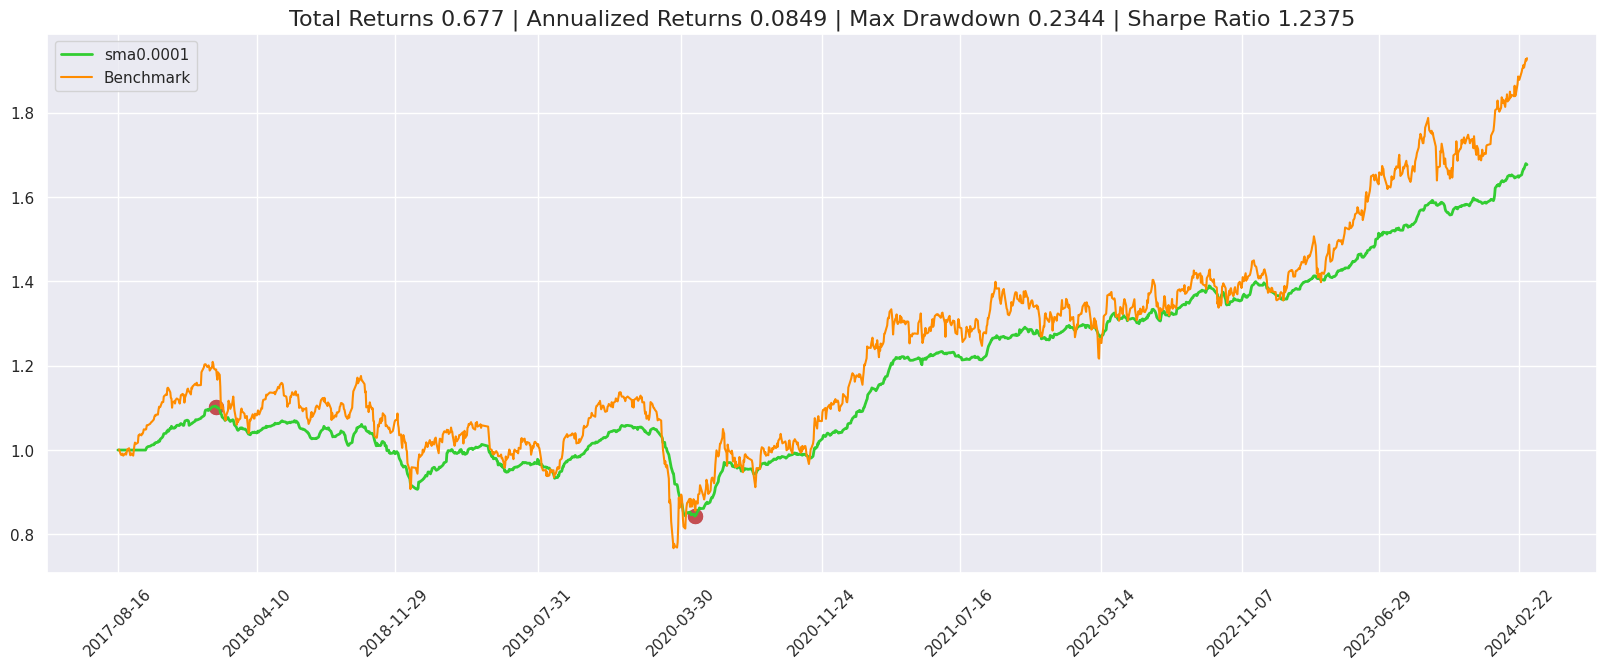

{'return': 0.677, 'annual_rate': 0.0849, 'max_drawdown': 0.2344, 'sharp_ratio': 1.2375}


In [ ]:
result = Backtest(data_loader, strategy, broker, name='lgbm').run()
print(result)

In [ ]:
#from src.strategy import Strategy
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

class gridStrategy:
    def __init__(self, broker=None, data_loader=None, risk_manage=True, model='random_forest'):
        self._broker = broker
        self.y = None
        self.x = None
        self.factors = None
        self._data = None
        self.pool = None
        self.last_tick = None
        self.grids = {}
        self.max_drawdown = 0.15
        self.take_profit_percent = 0.2
        self.stop_loss_percent = 0.05
        self.risk_manage = risk_manage
        if model == 'ridge':
            self.model = Ridge(alpha=0.5)
        elif model == 'random_forest':
            self.model = RandomForestRegressor(n_estimators=20, max_depth=3)
        else:
            self.model = LinearRegression()

    def init(self):

      self._data = self._broker.data_loader.data
      #self.factors = data_loader.factors#self._broker.data_loader.factors
      self.factors = pd.DataFrame()
      self.factors['vol_20'] = self._data.set_index('date').groupby('ticker').ewm(span=20).std(numeric_only=True)['last'].rename('vol_20')
      self.factors['vol_5'] = self._data.set_index('date').groupby('ticker').ewm(span=5).std(numeric_only=True)['last'].rename('vol_5')
      self.factors['upper'] = (self._data.set_index('date').groupby('ticker').rolling(window=20, min_periods=2).max()['last'] * 1.05).rename('upper')
      self.factors['lower'] = (self._data.set_index('date').groupby('ticker').rolling(window=20, min_periods=2).min()['last'] * 0.95).rename('lower')

      self._data = pd.concat([self._data.set_index(['ticker', 'date']), self.factors], axis=1).reset_index().set_index('date')
      self.pool = self._data['ticker'].unique()

    def buy(self, stock, volume):
        self._broker.buy(stock, volume)

    def sell(self, stock, volume=None):
        self._broker.sell(stock, volume)

    def get_grids(self, tick, tick_data):
        if len(self.grids)==0 or tick.isoweekday()==1: #datetime.fromtimestamp(tick.astype(datetime)/10**9).isoweekday() == 1:
            for p in self.pool:
                tmp = tick_data.loc[tick_data.ticker == p]
                upper = tmp.upper.values[0]
                lower = tmp.lower.values[0]
                grid_size = (upper - lower) / 10
                self.grids[p] = pd.Series([lower + i * grid_size for i in range(10 + 1)])
        return self.grids

    def gen_signal(self, crt_data, last_data):
        crt_data['signal'] = [0]*len(crt_data)
        # find out the stock belong to which grid
        for p in crt_data.ticker:
            crt_price = crt_data.loc[crt_data.ticker == p]['last'].values[0]
            last_price = last_data.loc[last_data.ticker == p]['last'].values[0]
            last_idx = self.grids[p].searchsorted(last_price)
            crt_idx = self.grids[p].searchsorted(crt_price)
            crt_data.loc[crt_data.ticker == p, 'signal'] = last_idx - crt_idx
        return crt_data[['signal', 'ticker']].set_index('ticker')

    def next(self, tick):
        tick_data = self._data.loc[tick]
        if tick_data.empty or self.last_tick is None:
            self.last_tick = tick
            return

        last_tick_data = self._data.loc[self.last_tick]
        self.grids = self.get_grids(tick, tick_data)

        vol = self._data.loc[tick][['vol_5', 'ticker']].reset_index(drop=True).set_index('ticker').vol_5
        # split into 5 groups based on signal
        vol = pd.qcut(vol, 5, labels=False, duplicates='drop')
        # buy the top 10% stocks
        target_stocks = vol[vol == 4].index.tolist()

        crt_target_data = tick_data.loc[tick_data.ticker.isin(target_stocks)]
        last_target_data = last_tick_data.loc[last_tick_data.ticker.isin(target_stocks)]
        signal = self.gen_signal(crt_target_data, last_target_data)
        buy_stocks = signal.loc[signal.signal >= 1].sort_values('signal', ascending=False).index
        sell_stocks = signal.loc[signal.signal <= -1].sort_values('signal').index

        # sell first and then buy
        for stock in sell_stocks:
            self.sell(stock, 100*len(tick_data)/len(sell_stocks))#100 #* abs(signal.loc[stock].signal))# *mkt_cap/total_cap

        for stock in buy_stocks:
            self.buy(stock, 100*len(tick_data)/len(buy_stocks))#100 #* abs(signal.loc[stock].signal))#
        #self.risk_manager()
        self.last_tick = tick

    def risk_manager(self):
      # Calculate the current portfolio value based on today's prices
      zero_count = 0
      for symbol, position in self._broker.position.items():
          if position == [0, 0]:
              zero_count += 1
          else:
              break
      if zero_count == len(self._broker.position):
          return False

      current_portfolio_value = self._broker.market_value
      # Calculate the drawdown
      drawdown = (self._broker.initial_cash - current_portfolio_value) / self._broker.initial_cash

      if drawdown > self.max_drawdown:
          # If drawdown exceeds the acceptable level, liquidate the portfolio
          for stock, pos in self._broker.position.items():
              if pos[0] > 0:
                  self.sell(stock)
          return True

      return False


strategy = gridStrategy(broker, risk_manage=True, model='ridge')


In [ ]:
import pandas as pd
#from .strategy import Strategy
#from .broker import Broker
from tqdm import tqdm
import numpy as np
import os

class Backtest:
    """
    Backtest class is used for reading historical market data,
    executing strategies, simulating trades, and estimating returns.
    Call Backtest.run during initialization to initiate the backtesting process.
    """

    def __init__(self, #data_loader,strategy: Strategy,broker: Broker,name: str):
                 data_loader,
                 strategy,
                 broker,
                 name: str):
        """
        Construct backtesting object. Required parameters include: historical data,
        strategy object, initial capital, commission rate, etc.
        The initialization process includes checking input types, filling data null values, etc.
        Parameters:
        :param data:           pd.DataFrame        Historical data in pandas DataFrame format
        :param broker:         type(Broker)        Broker type responsible for executing buy and sell operations
                                                   as well as maintaining account status.
        :param strategy:       type(Strategy)      Strategy Type
        :param cash:           float               Initial funding amount
        :param commission:     float               Transaction fee rate for each transaction. For example, if the fee is
                                                   .2%, then it should be entered as 0.002 here.
        """
        data = data_loader.data.copy(False)

        # Sort the market data by time if it is not already sorted.
        if not data.index.is_monotonic_increasing:
            data = data.sort_index()
        # Initialize exchange and strategy objects using data.
        self._data = data.reset_index()[['date', 'ticker', 'last']]
        self.ticks = self._data['date'].unique()

        self._broker = broker
        self._strategy = strategy
        self._results = None
        self.name = name


    def run(self):
        """
        Run backtesting, iterate through historical data, execute simulated trades, and return backtesting results.
        Run the backtest. Returns `pd.Series` with results and statistics.
        Keyword arguments are interpreted as strategy parameters.
        """
        strategy = self._strategy
        broker = self._broker
        # Strategy Initialization
        strategy.init()
        # Set the start and end positions for backtesting
        # Backtesting main loop, update market status, and execute strategy

        for tick in tqdm(self.ticks):
            # tick_data = self._data.loc[self._data['date'] == tick]
            broker.next(tick)
            strategy.next(tick)
            broker.write_ratio(tick)
            # self.write_ratio()

        # After completing the strategy execution, calculate the results and return them.
        res = broker.get_result()

        try: n = len(os.listdir('./results'))
        except:
          os.mkdir('./results')
          n = len(os.listdir('./results'))
        broker.save_result(path=f'./results/backtest_{self.name}_run_{n+1}')
        broker.plot_ratio(path=f'./results/backtest_{self.name}_run_{n+1}')

        return res


In [ ]:
result = Backtest(data_loader, strategy, broker, name='grid').run()
print(result)


串流輸出內容已截斷至最後 5000 行。
 23%|██▎       | 368/1599 [01:43<04:41,  4.37it/s]<ipython-input-109-b2f037ab7485>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crt_data['signal'] = [0]*len(crt_data)
 23%|██▎       | 369/1599 [01:44<06:07,  3.35it/s]<ipython-input-109-b2f037ab7485>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crt_data['signal'] = [0]*len(crt_data)
 23%|██▎       | 370/1599 [01:44<05:33,  3.69it/s]<ipython-input-109-b2f037ab7485>:58: SettingWithCopyWarning: 
A value is trying to be set on a co

<ipython-input-108-520e48a84865>:170: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self._data['ret'] = self._data.groupby('ticker')['last'].pct_change().shift(-1)


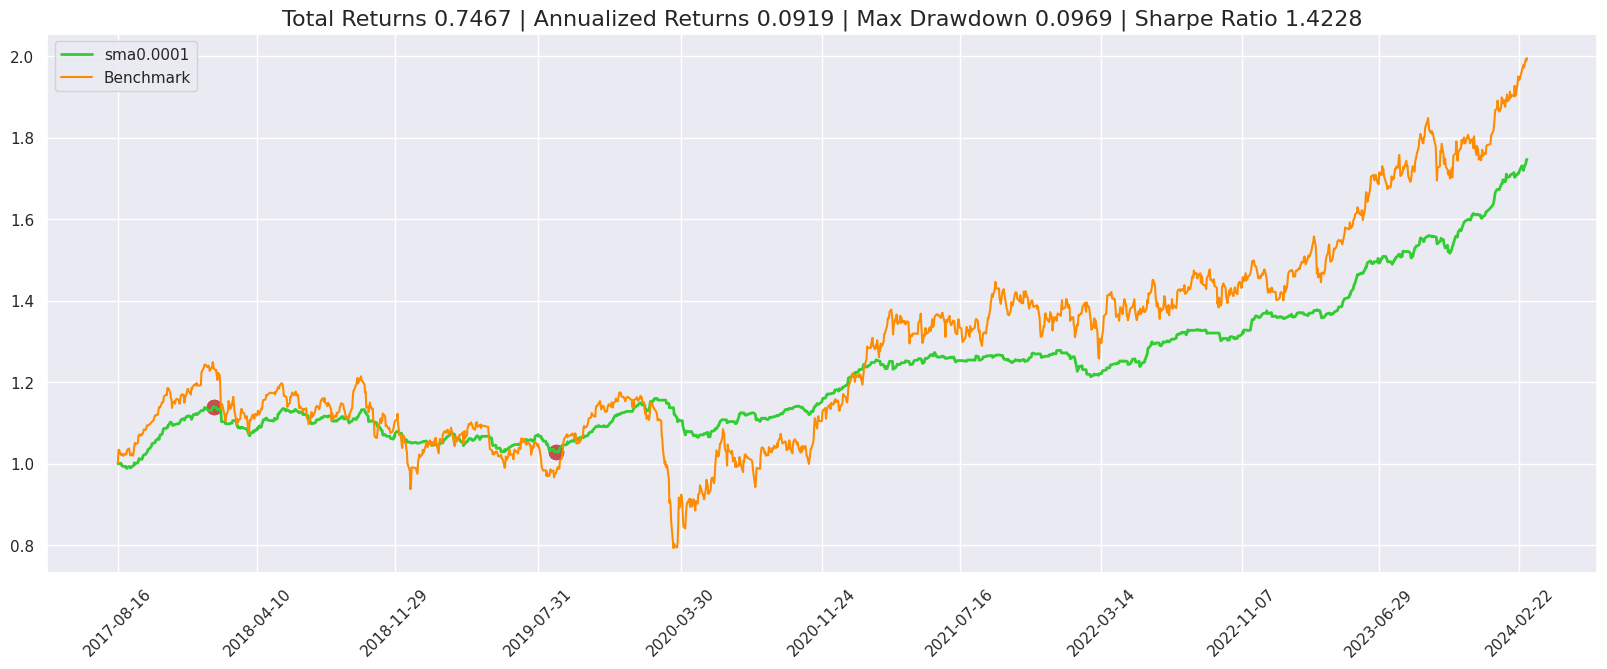

In [ ]:
broker.get_result()
try: n = len(os.listdir('./results'))
except:
  os.mkdir('./results')
  n = len(os.listdir('./results'))
broker.save_result(path=f'./results/backtest_grid_run_{n+1}')
broker.plot_ratio(path=f'./results/backtest_grid_run_{n+1}')

Streaming output truncated to the last 5000 lines.
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crt_data['signal'] = [0]*len(crt_data)
 48%|████▊     | 767/1599 [03:57<03:57,  3.50it/s]<ipython-input-23-333583a73196>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crt_data['signal'] = [0]*len(crt_data)
 48%|████▊     | 768/1599 [03:57<03:45,  3.69it/s]<ipython-input-23-333583a73196>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

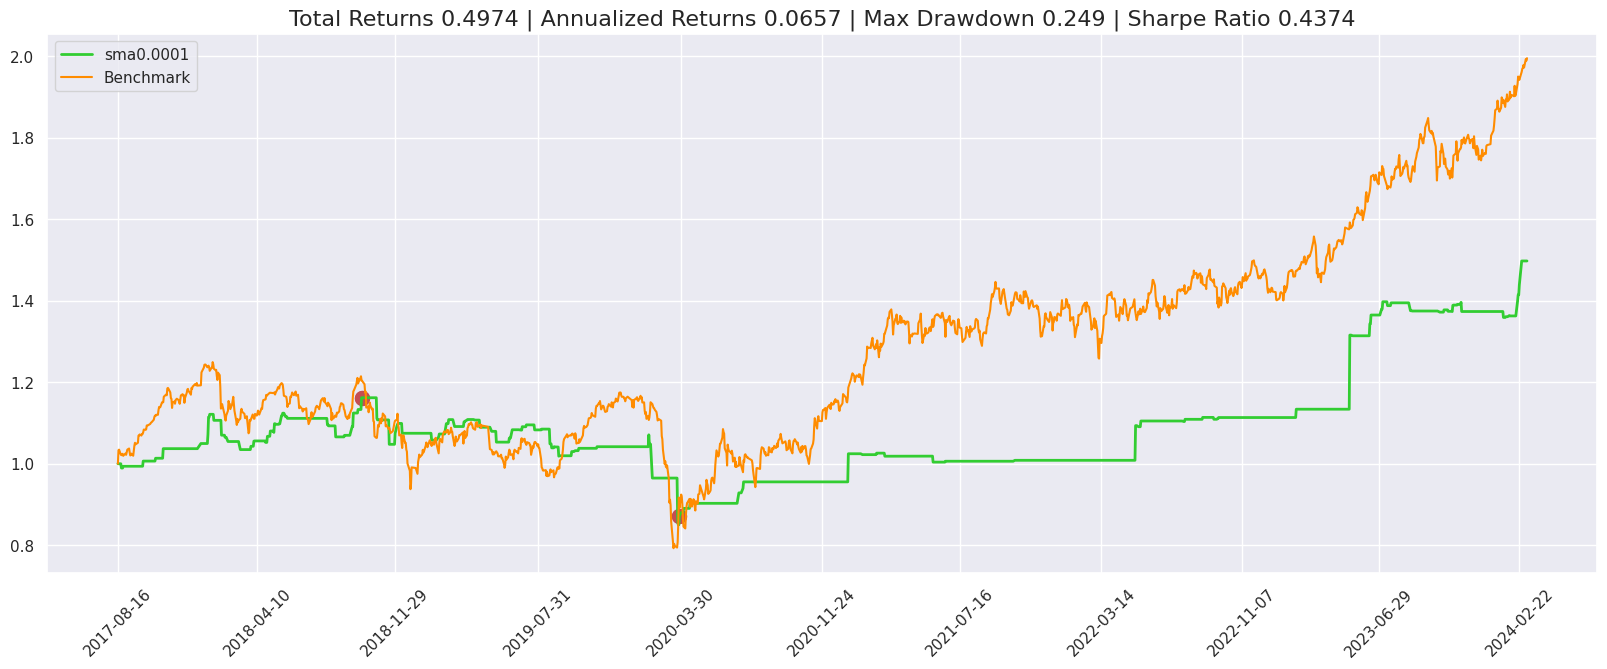

{'return': 0.4974, 'annual_rate': 0.0657, 'max_drawdown': 0.249, 'sharp_ratio': 0.4374}


In [ ]:
result = Backtest(data_loader, strategy, broker, name='grid').run()
print(result)

In [ ]:
broker._pos_history

{'1332 JT': [],
 '5411 JT': [[Timestamp('2017-08-25 00:00:00'), 'sell', 0, 1614.04],
  [Timestamp('2017-08-31 00:00:00'), 'sell', 0, 1676.56],
  [Timestamp('2017-11-29 00:00:00'), 'sell', 0, 2031.43],
  [Timestamp('2017-11-30 00:00:00'), 'sell', 0, 2068.22],
  [Timestamp('2017-12-01 00:00:00'), 'sell', 0, 2102.27],
  [Timestamp('2017-12-05 00:00:00'), 'sell', 0, 2146.5],
  [Timestamp('2018-07-26 00:00:00'), 'sell', 0, 1817.56],
  [Timestamp('2018-08-01 00:00:00'), 'sell', 0, 2003.88],
  [Timestamp('2018-08-07 00:00:00'), 'sell', 0, 2047.16],
  [Timestamp('2021-05-10 00:00:00'), 'sell', 0, 1476.47],
  [Timestamp('2021-08-30 00:00:00'), 'sell', 0, 1479.04],
  [Timestamp('2021-08-31 00:00:00'), 'sell', 0, 1527.82],
  [Timestamp('2021-11-12 00:00:00'), 'sell', 0, 1331.55],
  [Timestamp('2023-02-08 00:00:00'), 'buy', 100, 1462.62],
  [Timestamp('2023-02-09 00:00:00'), 'sell', 0, 1475.11],
  [Timestamp('2023-02-17 00:00:00'), 'sell', 0, 1637.41],
  [Timestamp('2023-02-20 00:00:00'), 'sell', 